Data Source :https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks  

Purpose of this analysis:  
APS Failure train and test data sets have a large feature space of 170 columns. Hence we need to look into which feature/column is important based on the given data (sparcity , variance ) . Ideally , we would consider the inputs from the business users with regards to any significance of the feature/column.    

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

In [18]:
from sklearn.metrics import  roc_auc_score, accuracy_score, classification_report, confusion_matrix, auc , roc_curve , precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_predict, cross_val_score , train_test_split, cross_validate, StratifiedKFold, GridSearchCV, KFold


In [19]:
from sklearn.feature_selection import RFE

In [20]:
import graphviz 
import sklearn.tree as tree

In [21]:
data = pd.read_csv("aps_failure_training_set.csv", skiprows = 19 )

In [22]:
test_data = pd.read_csv("aps_failure_test_set.csv", skiprows = 19)

In [10]:
data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [21]:
data.isnull().sum()

class     0
aa_000    0
ab_000    0
ac_000    0
ad_000    0
         ..
ee_007    0
ee_008    0
ee_009    0
ef_000    0
eg_000    0
Length: 171, dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [37]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 20.9+ MB


In [14]:
dtype = data.dtypes
print(dtype[dtype == 'int64'])
print("\n")
print(dtype.value_counts())

aa_000    int64
dtype: object


object    170
int64       1
dtype: int64


In [15]:
data['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [38]:
test_data['class'].value_counts()

neg    15625
pos      375
Name: class, dtype: int64

In [39]:
print("% of failures in train : {}".format((data[data['class'] =='pos'].shape[0]/data.shape[0]) * 100))

% of failures in train : 1.6666666666666667


In [40]:
print("% of failures in test : {}".format((test_data[test_data['class'] =='pos'].shape[0]/test_data.shape[0]) * 100))

% of failures in test : 2.34375


In [25]:
cols = data.columns
data[cols[2:]].head()

,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,na,2130706438,280,0,0,0,0,0,0,37250,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,na,0,na,0,0,0,0,0,0,18254,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,na,228,100,0,0,0,0,0,0,1648,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,70,66,0,10,0,0,0,318,2212,...,240,46,58,44,10,0,0,0,4,32
4,na,1368,458,0,0,0,0,0,0,43752,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [23]:
def convert_na(val):    
    if val == 'na':
        return np.NaN
    else: 
        return pd.to_numeric(val)
    

Convert 'na' to NaN . Drop the first two columns as they stand for 'class' and aa_000 which is integer type.

In [26]:
import time
start = time.process_time()
for d in cols[2:]:
    data[d] = data[d].apply(lambda x: convert_na(x))
print("Time taken : {}".format(time.process_time() - start))

Time taken : 261.96647299999995


In [27]:
## convert test data values to numeric 
start = time.process_time()
for d in cols[2:]:
    test_data[d] = test_data[d].apply(lambda x: convert_na(x))
print("Time taken : {}".format(time.process_time() - start))

Time taken : 86.305295


Check the columns for the missing values and sort them in the descending order of missing values.

In [20]:
null_columns = data.isnull().sum()
null_columns.sort_values(ascending = False)

br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
cr_000    46329
          ...  
cj_000      338
ck_000      338
bt_000      167
aa_000        0
class         0
Length: 171, dtype: int64

In [46]:
## any nan values in test data ?
test_data.isnull().sum()

class         0
aa_000        0
ab_000    12363
ac_000      926
ad_000     3981
          ...  
ee_007      192
ee_008      192
ee_009      192
ef_000      762
eg_000      762
Length: 171, dtype: int64

In [21]:
#drop the null values and check for the number of records and number of positive failiure cases,
data2 = data.copy()
print(data2.dropna().shape)
print(data2.dropna()['class'].value_counts())

(591, 171)
neg    515
pos     76
Name: class, dtype: int64


Hence all data is lost if we discard na records. We need to selectively impute the columns.Also drop the columns with low varaince.  

In [22]:
null_columns[null_columns == 0]

class     0
aa_000    0
dtype: int64

(array([143.,   2.,  11.,   5.,   1.,   1.,   0.,   0.,   2.,   6.]),
 array([    0. ,  4926.4,  9852.8, 14779.2, 19705.6, 24632. , 29558.4,
        34484.8, 39411.2, 44337.6, 49264. ]),
 <a list of 10 Patch objects>)

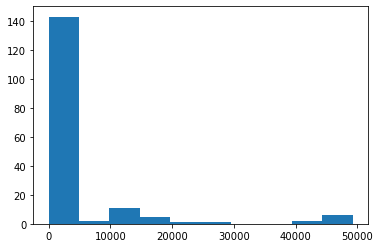

In [42]:
plt.hist(null_columns)

There are are about 140 columns having missing values of 5000 . Remaining 30 columns have missing values > 5000 , which is > 10% of the records.  

In [91]:
len(cols)

171

In [43]:
len(null_columns[null_columns > 5000])

28

Out of 170 columns, 28 columns have > 8% of missing values.  

In [44]:
## Any null values in test data ?
test_data.isnull().sum().sort_values(ascending = False)

eg_000    0
ba_000    0
ba_008    0
ba_007    0
ba_006    0
         ..
cq_000    0
cp_000    0
co_000    0
cn_009    0
class     0
Length: 171, dtype: int64

1. Check for records with positive cases , how many columns have null values?

In [86]:
data[data['class'] == 'pos'].isnull().sum().sort_values(ascending = False)

ab_000    771
cr_000    771
ch_000    645
co_000    645
ad_000    645
         ... 
cs_002      4
cn_007      4
by_000      1
aa_000      0
class       0
Length: 171, dtype: int64

In [28]:
pos_cols = data[data['class'] == 'pos'].isnull().sum()
pos_cols.quantile([0.25,0.5,0.75])

0.25      4.5
0.50     42.0
0.75    377.0
dtype: float64

In [29]:
len(pos_cols[pos_cols >=377])

48

There are 48 columns which have more than 377 missing values among the 1000 records for positive cases. 

In [30]:
pos_cols_to_drop = pos_cols[pos_cols >=377].index.tolist()

In [31]:
data_2 = data.copy()
data_2.drop(pos_cols_to_drop, axis = 1 , inplace = True)

In [32]:
data_2.shape

(60000, 123)

Drop the corresponding columns in test data.

In [33]:
test_2 = test_data.copy()
test_2.drop(pos_cols_to_drop, axis = 1 , inplace = True)

2. Among the 123 columns , check for variance. Drop the columns with variance below 50% percentile.  

In [34]:
data_2[data_2['class'] == 'pos'].var(axis = 0)

aa_000    1.886894e+11
ae_000    5.502028e+04
af_000    3.861780e+05
ag_000    4.948453e+08
ag_001    6.558390e+10
              ...     
ee_005    3.102306e+13
ee_006    2.117961e+13
ee_007    1.594161e+13
ee_008    4.749460e+12
ee_009    4.878552e+10
Length: 122, dtype: float64

In [28]:
variances = data_2.var(axis = 0)
variances

aa_000    2.114990e+10
ae_000    2.609626e+04
af_000    4.401293e+04
ag_000    4.193675e+08
ag_001    1.169676e+09
              ...     
ee_005    1.256741e+12
ee_006    1.143102e+12
ee_007    2.986178e+12
ee_008    2.020593e+11
ee_009    2.253442e+09
Length: 122, dtype: float64

In [29]:
variances.quantile([0.25,0.5,0.75])

0.25    1.003811e+10
0.50    2.646746e+11
0.75    3.231131e+12
dtype: float64

In [30]:
print("No of columns with var less than 25 percentile :{}".format(len(variances[variances < 1.003811e+10])))
print("No of columns with var less than 50 percentile :{}".format(len(variances[variances < 2.646746e+11])))

No of columns with var less than 25 percentile :31
No of columns with var less than 50 percentile :61


In [31]:
drop_cols = variances[variances < 2.646746e+11].index.tolist()

In [32]:
len(drop_cols)

61

In [33]:
## drop the columns with low variance
data_2.drop(drop_cols, axis = 1 ,inplace = True)

In [34]:
data_2.shape

(60000, 62)

In [48]:
test_2.drop(drop_cols , axis = 1, inplace = True)

In [49]:
test_2.shape

(16000, 62)

To summarise : We dropped the columns that have missing values more than 377 /1000 by subsetting the  data for positive cases. Then , we dropped the columns that have variance less than 50% of the variance distribution.   


In [103]:
## save the file 
data_2.to_csv("train_reduced.csv", index = False)

In [50]:
## save the file
test_2.to_csv("test_reduced.csv", index = False)